### Install Depencies

In [ ]:
# Common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from IPython.display import clear_output as cls

# Data
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

### Download Dataset Kaggle

#### Setup Kaggle API

In [ ]:
# Masukkan API Kaggle Akun Anda Dalam Berbentuk JSON
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#### Get Data Kaggle API

In [ ]:
 !kaggle datasets download -d utkarshsaxenadn/animal-image-classification-dataset/

100% 1.61G/1.61G [01:12<00:00, 25.1MB/s]
100% 1.61G/1.61G [01:12<00:00, 23.9MB/s]


In [ ]:
!unzip animal-image-classification-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Animal-Data-V2/Data-V2/Training Data/Tiger/Tiger (1000).jpeg  
  inflating: Animal-Data-V2/Data-V2/Training Data/Tiger/Tiger (1001).jpeg  
  inflating: Animal-Data-V2/Data-V2/Training Data/Tiger/Tiger (1002).jpeg  
  inflating: Animal-Data-V2/Data-V2/Training Data/Tiger/Tiger (1003).jpeg  
  inflating: Animal-Data-V2/Data-V2/Training Data/Tiger/Tiger (1004).jpeg  
  inflating: Animal-Data-V2/Data-V2/Training Data/Tiger/Tiger (1005).jpeg  
  inflating: Animal-Data-V2/Data-V2/Training Data/Tiger/Tiger (1006).jpeg  
  inflating: Animal-Data-V2/Data-V2/Training Data/Tiger/Tiger (1007).jpeg  
  inflating: Animal-Data-V2/Data-V2/Training Data/Tiger/Tiger (1008).jpeg  
  inflating: Animal-Data-V2/Data-V2/Training Data/Tiger/Tiger (1009).jpeg  
  inflating: Animal-Data-V2/Data-V2/Training Data/Tiger/Tiger (1010).jpeg  
  inflating: Animal-Data-V2/Data-V2/Training Data/Tiger/Tiger (1011).jpeg  
  inflating: Animal-Data-V2/Data-V2/T

### Data Information

In [ ]:
training_data = '/content/Animal Classification/Animal Classification/Training Data/'
class_names = sorted(os.listdir(training_data))
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(training_data + name)) for name in class_names]


# Show
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 5 
Class Names : ['Cat', 'Cow', 'Dog', 'Elephant', 'Panda']


In [ ]:
# Visualize
fig = px.bar(x=class_names, y=class_dis, title="Training Class Distribution", color=class_names)
fig.update_layout({'title':{'x':0.5}})
fig.show()


In [ ]:
# Class Names
validation_data = '/content/Animal Classification/Animal Classification/Validation Data/'

# Class Distribution
class_dis = [len(os.listdir(validation_data + name)) for name in class_names]

# Visualize
fig = px.bar(x=class_names, y=class_dis, title="Validation Class Distribution", color=class_names)
fig.update_layout({'title':{'x':0.5}})
fig.show()


In [ ]:
# Class Names
testing_data = '/content/Animal Classification/Animal Classification/Testing Data/'

# Class Distribution
class_dis = [len(os.listdir(testing_data + name)) for name in class_names]

# Visualize
fig = px.bar(x=class_names, y=class_dis, title="Testing Class Distribution", color=class_names)
fig.update_layout({'title':{'x':0.5}})
fig.show()

### Image Data Generator (Augmentasi)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

valid_datagen = ImageDataGenerator(rescale= 1.0 / 255)
test_datagen = ImageDataGenerator(rescale= 1.0 / 255)

In [ ]:
training_generator = train_datagen.flow_from_directory(
    training_data,
    class_mode = 'binary',
    target_size = (256,256),
    shuffle=True,
    batch_size = 32
)
valid_generator = valid_datagen.flow_from_directory(
    validation_data,
    class_mode='binary',
    target_size=(256,256),
    shuffle=True,
    batch_size=32
)

testing_generator = test_datagen.flow_from_directory(
    testing_data,
    class_mode = 'binary',
    target_size = (256,256),
    shuffle=True,
    batch_size = 32
)

Found 7500 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.
Found 1202 images belonging to 5 classes.


In [ ]:
for image_batch, label_batch in training_generator:
  break
image_batch.shape, label_batch.shape

((32, 256, 256, 3), (32,))

In [ ]:
print(training_generator.class_indices)

{'Cat': 0, 'Cow': 1, 'Dog': 2, 'Elephant': 3, 'Panda': 4}


### Transfer Learning

In [ ]:
# Load the base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False)
# Freeze the existing layers
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(n_classes, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 128)         1474688   
                                                                 
 dropout (Dropout)           (None, 5, 5, 128)         0         
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 3,733,317
Trainable params: 1,475,333
Non-

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
# Definisikan Callback agar ketika model telah sampai tujuan akan berhenti
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    v_acc = logs.get('val_acc')
    acc = logs.get('acc')
    if acc > 0.96 and v_acc > 0.96:
      print("\nReached 96% accuracy & val_accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
name = 'AnimalClassification_MobileNetV2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=name + '.h5',
    save_best_only=True)

In [ ]:
callbacks = myCallback()

### Model Training

In [ ]:
model = model.fit(
    training_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=2,
    callbacks=[callbacks, model_checkpoint_callback]
)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning:

Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 



235/235 - 149s - loss: 0.3210 - acc: 0.9251 - val_loss: 0.1766 - val_acc: 0.9476 - 149s/epoch - 634ms/step
Epoch 2/10
235/235 - 136s - loss: 0.0994 - acc: 0.9680 - val_loss: 0.2001 - val_acc: 0.9396 - 136s/epoch - 580ms/step
Epoch 3/10
235/235 - 136s - loss: 0.0791 - acc: 0.9736 - val_loss: 0.1639 - val_acc: 0.9508 - 136s/epoch - 578ms/step
Epoch 4/10
235/235 - 137s - loss: 0.0541 - acc: 0.9819 - val_loss: 0.1582 - val_acc: 0.9536 - 137s/epoch - 582ms/step
Epoch 5/10
235/235 - 136s - loss: 0.0525 - acc: 0.9812 - val_loss: 0.1662 - val_acc: 0.9520 - 136s/epoch - 577ms/step
Epoch 6/10
235/235 - 135s - loss: 0.0432 - acc: 0.9851 - val_loss: 0.2010 - val_acc: 0.9452 - 135s/epoch - 574ms/step
Epoch 7/10
235/235 - 136s - loss: 0.0429 - acc: 0.9852 - val_loss: 0.2011 - val_acc: 0.9464 - 136s/epoch - 578ms/step
Epoch 8/10
235/235 - 134s - loss: 0.0416 - acc: 0.9843 - val_loss: 0.2591 - val_acc: 0.9348 - 134s/epoch - 571ms/step
Epoch 9/10
235/235 - 137s - loss: 0.0291 - acc: 0.9903 - val_loss: 

In [ ]:
!cp /content/AnimalClassification_MobileNetV2.h5 /content/drive/MyDrive/

### Grafik Loss, Accuracy

In [ ]:
data = pd.DataFrame(model.history)

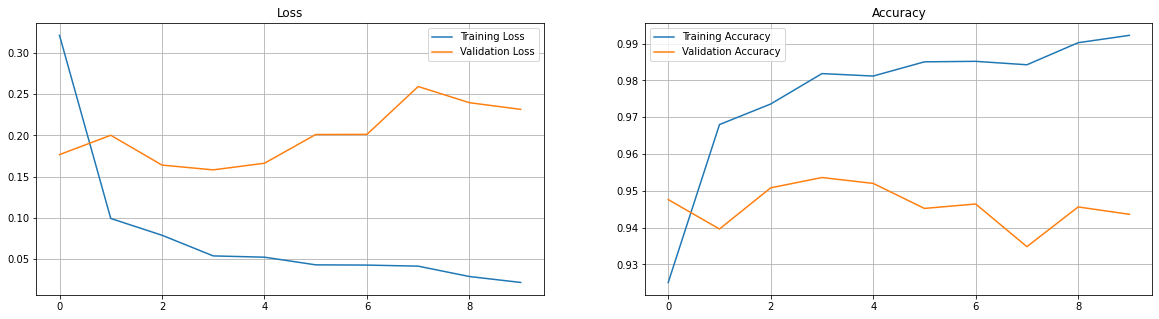

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(data.loss, label='Training Loss')
plt.plot(data.val_loss, label='Validation Loss')
plt.title("Loss")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(data.acc, label='Training Accuracy')
plt.plot(data.val_acc, label='Validation Accuracy')
plt.title("Accuracy")
plt.grid()
plt.legend()

plt.show()

### Model Evaluation

In [ ]:
model = tf.keras.models.load_model('/content/AnimalClassification_MobileNetV2.h5')

In [ ]:
model.evaluate(testing_generator, batch_size=64, verbose=2)

38/38 - 7s - loss: 0.2018 - acc: 0.9359 - 7s/epoch - 184ms/step


[0.20184452831745148, 0.9359400868415833]

### Model Predict

In [ ]:
def load_image(path):
    '''This function will load the image present at the given location'''
    image = tf.cast(tf.image.resize(img_to_array(load_img(path))/255., (224,224)), tf.float32)
    return image

In [ ]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)

#### Cat

1/1 [==============================] - 2s 2s/step
Pred : Cat
Confidence : 1.0


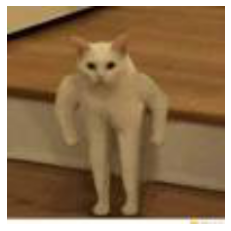

In [ ]:
uploaded = '/content/Animal Classification/Animal Classification/Interesting Images/Cat/Cat-Stand.jpeg'

images = load_image(uploaded)
show_image(images)
#Predict
preds = model.predict(images[np.newaxis,...])[0]
pred_class = class_names[np.argmax(preds)]
confidence_score = np.round(preds[np.argmax(preds)],2)

print(f"Pred : {pred_class}\nConfidence : {confidence_score:.2}")

#### Cow

1/1 [==============================] - 0s 109ms/step
Pred : Cow
Confidence : 0.98


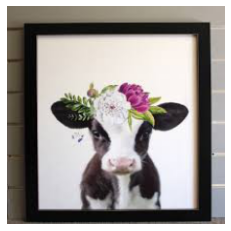

In [ ]:
uploaded = '/content/Animal Classification/Animal Classification/Interesting Images/Cow/cow-frame.jpeg'

images = load_image(uploaded)
show_image(images)
#Predict
preds = model.predict(images[np.newaxis,...])[0]
pred_class = class_names[np.argmax(preds)]
confidence_score = np.round(preds[np.argmax(preds)],2)

print(f"Pred : {pred_class}\nConfidence : {confidence_score:.2}")

#### Dog

1/1 [==============================] - 0s 19ms/step
Pred : Dog
Confidence : 1.0


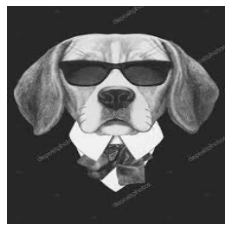

In [ ]:
uploaded = '/content/Animal Classification/Animal Classification/Interesting Images/Dog/Dog-Sketch.jpeg'

images = load_image(uploaded)
show_image(images)
#Predict
preds = model.predict(images[np.newaxis,...])[0]
pred_class = class_names[np.argmax(preds)]
confidence_score = np.round(preds[np.argmax(preds)],2)

print(f"Pred : {pred_class}\nConfidence : {confidence_score:.2}")

### References


1.   Dataset: https://www.kaggle.com/datasets/utkarshsaxenadn/animal-image-classification-dataset
2.   https://www.analyticsvidhya.com/blog/2022/01/image-classification-using-machine-learning/
3. https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/
4. https://towardsdatascience.com/transfer-learning-for-image-classification-using-tensorflow-71c359b56673
5. https://www.tensorflow.org/guide/saved_model
6. https://www.tensorflow.org/guide/keras/save_and_serialize#keras_h5_format
7. https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
